# 1. import libraries & functions

In [1]:
import pycalphad
import numpy as np
import matplotlib.pyplot as plt
from pycalphad import binplot, Database, calculate, equilibrium, variables as v
from scipy.optimize import curve_fit, fsolve
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from thermo_utilities import create_mask, truncate_colormap, interpolate_fit_windows, fit_and_plot_coeffs, calculate_common_tangent

In [21]:
'''
# ========== define the colormap ==========
# Use a subset of the colormap by selecting a range
def truncate_colormap(cmap, min_val=0.2, max_val=0.8, n=256):
    new_cmap = plt.cm.colors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{min_val:.2f},{max_val:.2f})',
        cmap(np.linspace(min_val, max_val, n)))
    return new_cmap

# ========== do temperature interpolation ==========
def interpolate_fit_windows(T, T_min, T_max):
    # Simple clamped linear interpolation from T_min to T_max
    alpha = (T - T_min) / (T_max - T_min)
    alpha = max(0.0, min(1.0, alpha))  # Clamp between 0 and 1
    print(f"T = {T:.2f} K, alpha = {alpha:.3f}")
    return {
        key: int(round(fit_windows_lowT[key] * (1 - alpha) + fit_windows_highT[key] * alpha))
        for key in fit_windows_lowT
    }

# ========== fit & plot ==========
# Function to fit and plot coefficients
def fit_and_plot_coeffs(coeffs, phase, index):
    fit_params = np.polyfit(temperatures, coeffs, 1)
    plt.figure(figsize=(10, 6))
    plt.plot(temperatures, coeffs, 'o', label=f'{phase} Coeff[{index}] Data')
    plt.plot(temperatures, fit_params[0] * temperatures + fit_params[1], '-', label=f'{phase} Coeff[{index}] Fit: {fit_params[0]:.3e}*T + {fit_params[1]:.3e}')
    plt.xlabel('Temperature (K)')
    plt.ylabel(f'{phase} Fit Coefficient [{index}]')
    plt.title(f'Temperature Dependency of {phase} Coefficient [{index}]')
    plt.legend()
    plt.grid(True)
    plt.show()
    return fit_params

# ========== Tangent Solver ==========
def calculate_common_tangent(A1, B1, C1, A2, B2, C2):
    df1 = lambda x: 2*A1*(x - B1)
    df2 = lambda x: 2*A2*(x - B2)
    f1  = lambda x: A1*(x - B1)**2 + C1
    f2  = lambda x: A2*(x - B2)**2 + C2
    def system(x): return [df1(x[0]) - df2(x[1]), f1(x[0]) - df1(x[0])*x[0] - (f2(x[1]) - df2(x[1])*x[1])]
    return fsolve(system, [B1, B2])
'''

# 2. define the database

In [2]:
# element data from that universal kinetic tdb file
# the rest parameters from : https://www.sciencedirect.com/science/article/pii/S0925838816319958

tdb_content = """
$
$=======================ELEMENT DATA===========================
$$ ELEMENT STABLE ELEMENT  REFERENCE	  MASS	      H298-H0	   S298
ELEMENT AL   FCC_A1                    2.6982E+01  4.5773E+03  2.8322E+01!
ELEMENT IN   TETRAGONAL_A6             1.1482E+02  6.6100E+03  5.7650E+01!
ELEMENT VA   VACUUM                    0.0000E+00  0.0000E+00  0.0000E+00!


$-------------------------------------------------------------------------------
$ FUNCTIONS FOR PURE AND OTHERS
$-------------------------------------------------------------------------------
FUNCTION GHSERAL  2.98140E+02  -7976.15 + 137.093038*T - 24.3671976*T*LN(T) - 1.884662E-03*T**2 - 0.877664E-06*T**3 + 74092*T**(-1);  7.00E+02  Y
         -11276.24 + 223.048446*T - 38.5844296*T*LN(T) + 18.531982E-03*T**2 - 5.764227E-06*T**3 + 74092*T**(-1);  9.3347E+02  Y
         -11278.378 + 188.684153*T - 31.748192*T*LN(T) - 1.231E+28*T**(-9);  2.9000E+03  N !

FUNCTION GHSERIN  2.98140E+02 -6978.89 + 92.338115*T - 21.8386*T*LN(T) - 5.72566E-03*T**2 - 2.120321E-06*T**3 - 22906*T**(-1);  4.2975E+02  Y
         -7033.516 + 124.476588*T - 27.4562*T*LN(T) + 0.54607E-03*T**2 - 0.08367E-06*T**3 - 211708*T**(-1) + 3.53E+22*T**(-9);  3.80000E+03  N !

FUNCTION GINFCC     298.15  + 123 - 0.1988*T + GHSERIN#;               1700 N !

FUNCTION  GALLIQ   298.15
    +3029.403+125.2307*T-24.36720*T*LN(T)-1.884662E-3*T**2-0.877664E-6*T**3
    +74092*T**(-1)+79.401E-21*T**7;                                   700.00 Y
    -270.6860+211.1861*T-38.58443*T*LN(T)+18.53198E-3*T**2-5.764227E-6*T**3
    +74092*T**(-1)+79.401E-21*T**7;                                    933.6 Y
    -795.7090+177.4100*T-31.74819*T*LN(T);                           2900.00 N !

FUNCTION GINLIQ     298.15
    +3282.092-7.63686*T -5.59E-20*T**7+GHSERIN#;                      429.75 Y
    +3283.706-7.640804*T-3.53E+22*T**(-9)+GHSERIN#;                    3800 N !
$-------------------------------------------------------------------------------
TYPE_DEFINITION % SEQ *!
DEFINE_SYSTEM_DEFAULT ELEMENT 2 !
DEFAULT_COMMAND DEF_SYS_ELEMENT VA /- !


$-------------------------------------------------------------------------------
$ FUNCTIONS FOR FCC_A1
$-------------------------------------------------------------------------------
PHASE FCC_A1  %  1  1.0  !
CONSTITUENT FCC_A1  :AL,IN :  !
  PARAMETER G(FCC_A1,AL;0)      298.15  +GHSERAL#;                     2900 N !
  PARAMETER G(FCC_A1,IN;0)      298.15  +GINFCC#;                      1700 N !
  PARAMETER G(FCC_A1,AL,IN;0)   298.15  +80.0*T;             6000 N !


$-------------------------------------------------------------------------------
$ PARAMETERS FOR LIQUID PHASE
$-------------------------------------------------------------------------------
PHASE LIQUID %  1  1.0  !
CONSTITUENT LIQUID :AL,IN :  !
  PARAMETER G(LIQUID,AL;0)      298.15  +GALLIQ#;                      2900 N !
  PARAMETER G(LIQUID,IN;0)      298.15  +GINLIQ#;                      3800 N !
  PARAMETER G(LIQUID,AL,IN;0)   298.15  +21259.6-0.48737*T;            6000 N !
  PARAMETER G(LIQUID,AL,IN;1)   298.15  +3850.3 -1.20564*T;            6000 N !
  PARAMETER G(LIQUID,AL,IN;2)   298.15  +5479.2 -3.16805*T;            6000 N !

"""

# 3. calculate and plot the phase diagram

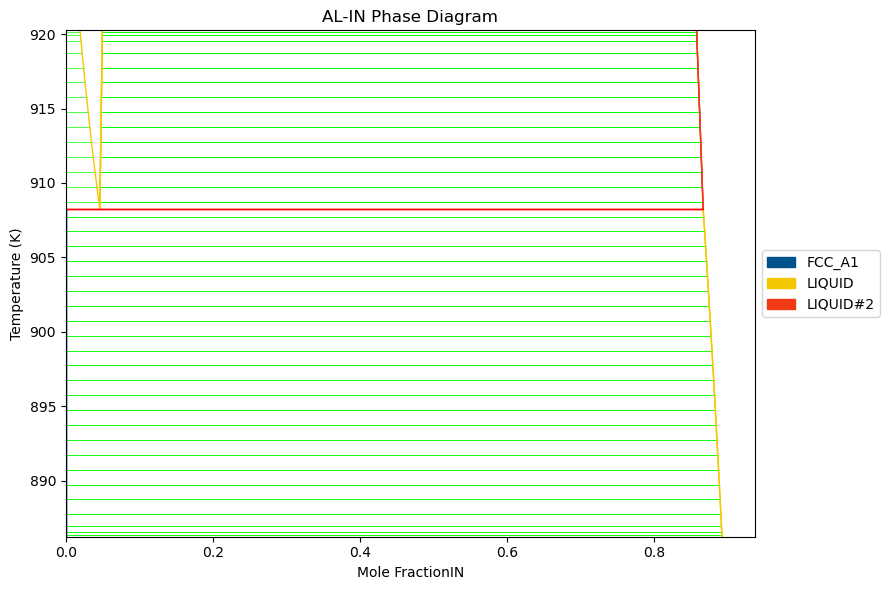

In [3]:
# ========== Settings ==========
T_min = 886.25 # Kelvin
T_max = 920.25 # Kelvin
T_interval = 1
C_min = 0.0
C_max = 1.0
C_interval = 0.02
Pressure = 101325 # Pascals
my_phases = ['LIQUID', 'FCC_A1']
my_elements = ['AL', 'IN', 'VA']
reference_element = 'IN'

# ========== Plotting ==========
fig, ax = plt.subplots(figsize=(9,6))

binplot(tdb_content, my_elements, my_phases,
        {v.X(reference_element):(C_min, C_max, C_interval), v.T:(T_min, T_max, T_interval), v.P:Pressure, v.N:1},
        plot_kwargs={'ax': ax})


# === Labels ===
ax.set_xlabel('Mole Fraction' + reference_element)
ax.set_ylabel('Temperature (K)')
ax.set_title(my_elements[0] + '-' + my_elements[1] + ' Phase Diagram')

plt.tight_layout()
plt.show()


# 4. calculate Gibbs free energy & equilibrium @ a given temperature

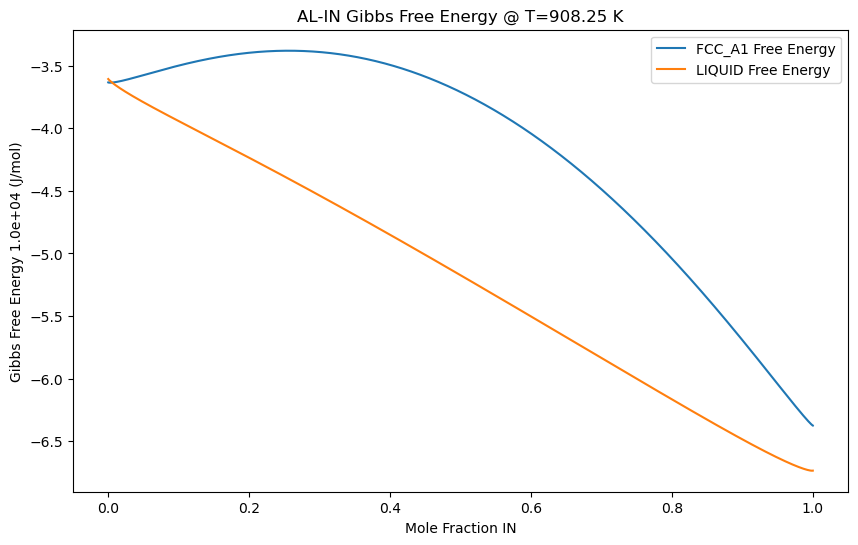

In [4]:
# ========== Create the database ==========
db = Database(tdb_content)

# ========== Settings ==========
# Define the temperature
Te = 908.25 # Kelvin

# Initialize arrays to store Gibbs free energy values
solid_free_energy = []
l1_free_energy = []

# phase names
solid_phase_name = 'FCC_A1'
liquid_phase_name = 'LIQUID'

# energy scale
energy_scale = 1e-4

# ========== solid gibbs free energy calculation ==========
solid_result = calculate(db, my_elements, solid_phase_name, P=Pressure, T=Te, output='GM', pdens=1000000)
x_solid = solid_result.X.sel(component=reference_element).data[0][0][0]
solid_free_energy = solid_result.GM.data[0][0][0]

# Get the indices that would sort x_solid
sorted_indices = np.argsort(x_solid)
# Sort x_solid using the sorted indices
x_solid_sorted = x_solid[sorted_indices]
# Sort solid_free_energy using the same indices
solid_free_energy_sorted = solid_free_energy[sorted_indices] * energy_scale


# ========== l1 gibbs free energy calculation ==========
l1_result = calculate(db, my_elements, liquid_phase_name, P=Pressure, T=Te, output='GM', pdens=1000000)
x_l1 = l1_result.X.sel(component=reference_element).data[0][0][0]
l1_free_energy = l1_result.GM.data[0][0][0]

# Get the indices that would sort x_solid
sorted_indices = np.argsort(x_l1)
# Sort x_solid using the sorted indices
x_l1_sorted = x_l1[sorted_indices]
# Sort solid_free_energy using the same indices
l1_free_energy_sorted = l1_free_energy[sorted_indices] * energy_scale


# ========== Plotting ==========
plt.figure(figsize=(10, 6))
plt.plot(x_solid_sorted, solid_free_energy_sorted, label=solid_phase_name + ' Free Energy')
plt.plot(x_l1_sorted, l1_free_energy_sorted, label=liquid_phase_name + ' Free Energy')
plt.xlabel('Mole Fraction ' + reference_element)
plt.ylabel('Gibbs Free Energy ' + f"{1/energy_scale:.1e}" + ' (J/mol)')
plt.title(my_elements[0] + '-' + my_elements[1] + ' Gibbs Free Energy @ T=' + str(Te) + ' K')
plt.legend()
plt.grid(False)
plt.show()


In [5]:
# ========== Settings ==========
Pressure = 101325 # Pascals
my_phases = ['LIQUID', 'FCC_A1']
my_elements = ['AL', 'IN', 'VA']
reference_element = 'IN'

# Define the temperature
Te = 908.25 # Kelvin

# define the concentration range
x_min = 0
x_max = 0.1
x_interval = 0.01


# ========== Perform equilibrium calculation at the given temperature and pressure ==========
eq_result = equilibrium(db, my_elements, my_phases, {v.P: Pressure, v.T: Te, v.X(reference_element): (x_min, x_max, x_interval)})


# ========== Print Equilibrium Results ==========
print(eq_result)
# Print equilibrium compositions
for x_in in eq_result.coords['X_IN'].values:
    # Extract all compositions at the current X_IN that have non-zero phase fractions
    phase_fractions = eq_result['NP'].sel(X_IN=x_in).values.squeeze()
    compositions = eq_result['X'].sel(X_IN=x_in).values.squeeze()
    phases = eq_result['Phase'].sel(X_IN=x_in).values.squeeze()

    print(f"In composition: {x_in:.6f}")
    for i, fraction in enumerate(phase_fractions):
        if not np.isnan(fraction) and fraction > 0:
            comp_al = compositions[i, 0]
            comp_in = compositions[i, 1]
            phase_name = phases[i]
            print(f"  Phase: {phase_name}, AL: {comp_al:.6f}, IN: {comp_in:.6f}")

<xarray.Dataset> Size: 2kB
Dimensions:    (N: 1, P: 1, T: 1, X_IN: 10, vertex: 3, component: 2,
                internal_dof: 2)
Coordinates:
  * N          (N) float64 8B 1.0
  * P          (P) float64 8B 1.013e+05
  * T          (T) float64 8B 908.2
  * X_IN       (X_IN) float64 80B 1e-10 0.01 0.02 0.03 ... 0.06 0.07 0.08 0.09
  * vertex     (vertex) int64 24B 0 1 2
  * component  (component) <U2 16B 'AL' 'IN'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_IN, vertex) float64 240B 1.0 nan nan ... 0.05336 nan
    GM         (N, P, T, X_IN) float64 80B -3.635e+04 -3.666e+04 ... -3.92e+04
    MU         (N, P, T, X_IN, component) float64 160B -3.635e+04 ... -6.803e+04
    X          (N, P, T, X_IN, vertex, component) float64 480B 1.0 1e-10 ... nan
    Y          (N, P, T, X_IN, vertex, internal_dof) float64 480B 1.0 ... nan
    Phase      (N, P, T, X_IN, vertex) <U6 720B 'FCC_A1' '' '' ... 'LIQUID' ''
Attributes:
    engine:   pycalphad 0.11.0
  

In [6]:
# ========== Settings ==========
# obtained equilbrium composition values
x_solid_eq = 0.000038
x_l1_eq = 0.046184
x_l2_eq = 0.867292

energy_solid_eq = np.interp(x_solid_eq, x_solid_sorted, solid_free_energy_sorted)
energy_l1_eq = np.interp(x_l1_eq, x_l1_sorted, l1_free_energy_sorted)

#print(energy_solid_eq)
#print(energy_l1_eq)

# Calculate the common tangent data
common_tangent_slope    = (energy_l1_eq-energy_solid_eq)/(x_l1_eq-x_solid_eq)
common_tangent_intercept    = (energy_solid_eq - common_tangent_slope*x_solid_eq)

print(common_tangent_slope)
print(common_tangent_intercept)

-3.1678001321596385
-3.634756630227412


# 5. calculate Gibbs free energy & fitting in a temperature range

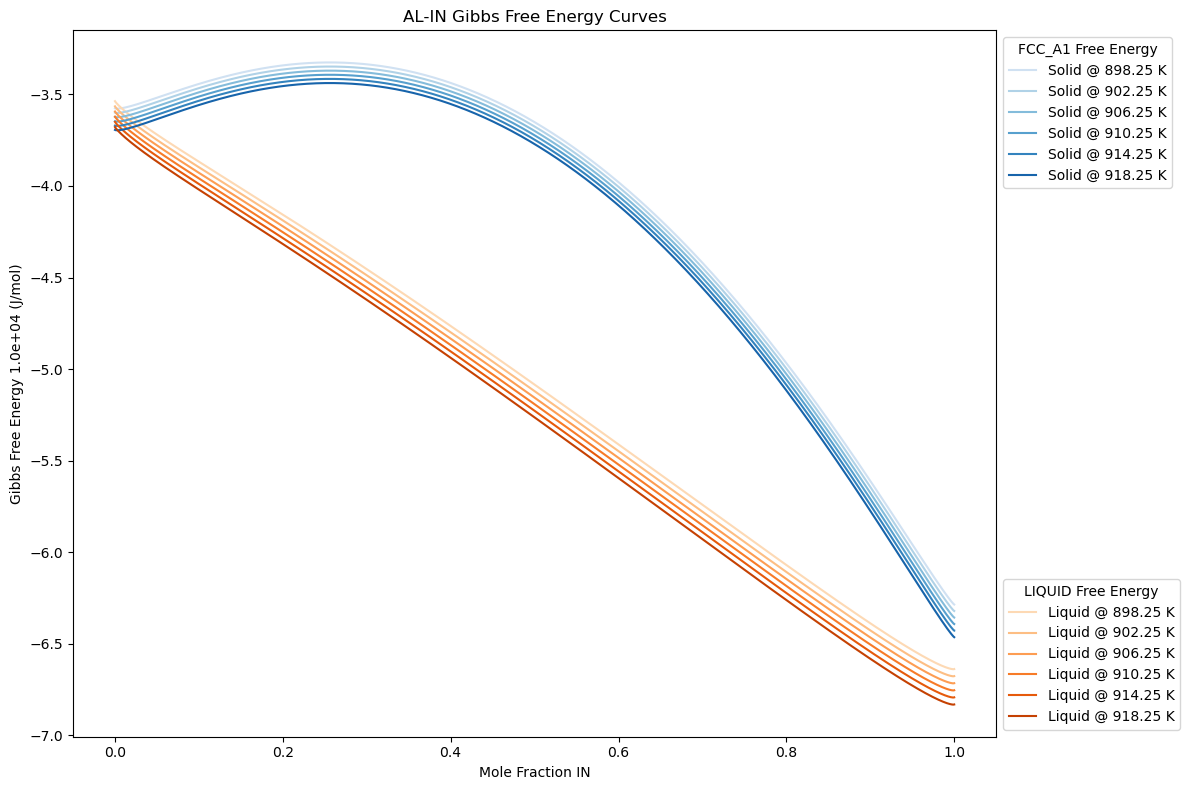

In [7]:
# ========== Settings ==========
Te = 908.25
# Define the temperatures range
range = 10
step = 4
T_range = np.linspace(Te-range, Te+range, int((range*2)/step)+1)

# Define the range of Nd composition
x_nd_range = np.linspace(0, 0.1, 100)

# Dictionary to store results for each temperature
results = {}

# ========== calculate the Gibbs free energies ==========
# Iterate over each temperature and calculate the Gibbs free energies
for T in T_range:
    solid_result = calculate(db, my_elements, solid_phase_name, P=Pressure, T=T, output='GM', pdens=1000000)
    x_solid = solid_result.X.sel(component=reference_element).data[0][0][0]
    solid_free_energy = solid_result.GM.data[0][0][0]

    l1_result = calculate(db, my_elements, liquid_phase_name, P=Pressure, T=T, output='GM', pdens=1000000)
    x_l1 = l1_result.X.sel(component=reference_element).data[0][0][0]
    l1_free_energy = l1_result.GM.data[0][0][0]

    # Sort the values
    sorted_indices_solid = np.argsort(x_solid)
    x_solid_sorted = x_solid[sorted_indices_solid]
    solid_free_energy_sorted = solid_free_energy[sorted_indices_solid] * energy_scale

    sorted_indices_l1 = np.argsort(x_l1)
    x_l1_sorted = x_l1[sorted_indices_l1]
    l1_free_energy_sorted = l1_free_energy[sorted_indices_l1] * energy_scale

    # Store the sorted data in the dictionary
    results[T] = {
        'x_solid': x_solid_sorted,
        'solid_free_energy': solid_free_energy_sorted,
        'x_l1': x_l1_sorted,
        'l1_free_energy': l1_free_energy_sorted
    }

# ========== define the colormap ==========
# Use truncated colormaps
cmap_solid = truncate_colormap(plt.colormaps['Blues'])
cmap_liquid = truncate_colormap(plt.colormaps['Oranges'])

# Normalize the temperatures for color mapping
norm = Normalize(vmin=min(T_range), vmax=max(T_range))


# ========== Plotting ==========
# Create a figure for plotting
plt.figure(figsize=(16, 8))

# Lists to hold legend handles
solid_handles = []
liquid_handles = []

# Iterate over each temperature stored in results
for T, data in results.items():
    x_solid = data['x_solid']
    solid_free_energy = data['solid_free_energy']
    x_l1 = data['x_l1']
    l1_free_energy = data['l1_free_energy']

    # Determine colors based on temperature using the truncated colormap
    color_solid = cmap_solid(norm(T))
    color_liquid = cmap_liquid(norm(T))

    # Plot solid phase and collect handle for legend
    solid_line, = plt.plot(x_solid, solid_free_energy, color=color_solid, linestyle='-')
    solid_handles.append((solid_line, f'Solid @ {T:.2f} K'))

    # Plot liquid phase and collect handle for legend
    liquid_line, = plt.plot(x_l1, l1_free_energy, color=color_liquid, linestyle='-')
    liquid_handles.append((liquid_line, f'Liquid @ {T:.2f} K'))

# Adding plot details
plt.xlabel('Mole Fraction ' + reference_element)
plt.ylabel('Gibbs Free Energy ' + f"{1/energy_scale:.1e}" + ' (J/mol)')
plt.title(my_elements[0] + '-' + my_elements[1] + ' Gibbs Free Energy Curves')

# Creating separate legends
solid_legend = plt.legend(*zip(*solid_handles), title=solid_phase_name + ' Free Energy', loc='upper left', bbox_to_anchor=(1, 1))
liquid_legend = plt.legend(*zip(*liquid_handles), title=liquid_phase_name + ' Free Energy', loc='lower left', bbox_to_anchor=(1, 0))

# Add the legends to the plot
plt.gca().add_artist(solid_legend)

# Set layout for better spacing between plot and legend
plt.tight_layout(rect=[0, 0, 0.75, 1])

# Show plot without grid
plt.grid(False)
plt.show()


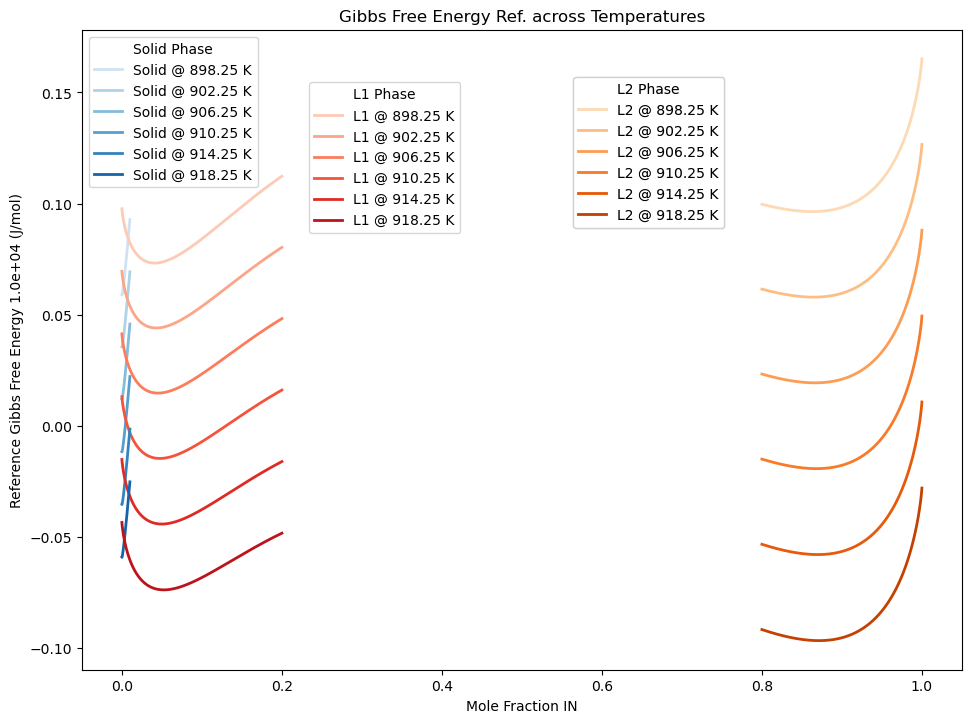

In [9]:
# ========== define the colormap ==========
# Use the truncated colormap for plotting
cmap_solid = truncate_colormap(plt.colormaps['Blues'])
cmap_l1 = truncate_colormap(plt.colormaps['Reds'])
cmap_l2 = truncate_colormap(plt.colormaps['Oranges'])

# Normalize the temperatures for color mapping
norm = Normalize(vmin=min(T_range), vmax=max(T_range))


# ========== Settings ==========
mask_solid_min = 0.0
mask_solid_max = 0.01
mask_l1_min = 0.0
mask_l1_max = 0.2
mask_l2_min = 0.8
mask_l2_max = 1.0

# ========== Plotting ==========
# Create a figure for plotting
plt.figure(figsize=(16, 8))

# Lists to hold legend handles
solid_handles = []
l1_handles = []
l2_handles = []

# Iterate over each temperature stored in results and plot them
for T, data in results.items():
    x_solid_sorted = data['x_solid']
    solid_free_energy_sorted = data['solid_free_energy']
    x_l1_sorted = data['x_l1']
    l1_free_energy_sorted = data['l1_free_energy']
    x_l2_sorted = data['x_l1']  # Assuming similar data for x_l2

    # Apply masks to select equilibrium regions
    mask_solid = (x_solid_sorted >= mask_solid_min) & \
                 (x_solid_sorted <= mask_solid_max)
    mask_l1 = (x_l1_sorted >= mask_l1_min) & \
              (x_l1_sorted <= mask_l1_max)
    mask_l2 = (x_l2_sorted >= mask_l2_min) & \
              (x_l2_sorted <= mask_l2_max)

    x_solid = x_solid_sorted[mask_solid]
    x_l1 = x_l1_sorted[mask_l1]
    x_l2 = x_l2_sorted[mask_l2]

    solid_free_energy = solid_free_energy_sorted[mask_solid]
    l1_free_energy = l1_free_energy_sorted[mask_l1]
    l2_free_energy = l1_free_energy_sorted[mask_l2]

    # Calculate reference energies
    energy_solid_reref = solid_free_energy - (common_tangent_slope * x_solid + common_tangent_intercept)
    energy_L1_reref = l1_free_energy - (common_tangent_slope * x_l1 + common_tangent_intercept)
    energy_L2_reref = l2_free_energy - (common_tangent_slope * x_l2 + common_tangent_intercept)

    # Determine colors based on temperature using the truncated colormap
    color_solid = cmap_solid(norm(T))
    color_l1 = cmap_l1(norm(T))
    color_l2 = cmap_l2(norm(T))

    # Plot the energies, using the colormap for differentiation
    solid_line, = plt.plot(x_solid, energy_solid_reref, '-', color=color_solid, linewidth=2)
    l1_line, = plt.plot(x_l1, energy_L1_reref, '-', color=color_l1, linewidth=2)
    l2_line, = plt.plot(x_l2, energy_L2_reref, '-', color=color_l2, linewidth=2)

    solid_handles.append((solid_line, f'Solid @ {T:.2f} K'))
    l1_handles.append((l1_line, f'L1 @ {T:.2f} K'))
    l2_handles.append((l2_line, f'L2 @ {T:.2f} K'))

# add lengds
solid_legend = plt.legend(*zip(*solid_handles), title="Solid Phase", loc='upper left', bbox_to_anchor=(0., 1))
plt.gca().add_artist(solid_legend)
l1_legend = plt.legend(*zip(*l1_handles), title="L1 Phase", loc='center left', bbox_to_anchor=(0.25, 0.8))
plt.gca().add_artist(l1_legend)
l2_legend = plt.legend(*zip(*l2_handles), title="L2 Phase", loc='lower left', bbox_to_anchor=(0.55, 0.68))
plt.gca().add_artist(l2_legend)
plt.subplots_adjust(left=0.1, right=0.65, top=0.9, bottom=0.1)

# Adding plot details
plt.xlabel('Mole Fraction ' + reference_element)
plt.ylabel('Reference Gibbs Free Energy ' + f"{1/energy_scale:.1e}" + ' (J/mol)')
plt.title('Gibbs Free Energy Ref. across Temperatures')
plt.grid(False)


# Show the plot
plt.show()

In [13]:
# === Compute coeff[0] for solid and L2 at T = Te ===

# ========== Settings ==========
fit_num = 5

fit_windows_highT = {
    "solid_left": 20,
    "solid_right": 200000,
    "l1_left": 40000,
    "l1_right": 10000,
    "l2_left": 40000,
    "l2_right": 10000,
}

fit_windows_lowT = {
    "solid_left": 20,
    "solid_right": 200000,
    "l1_left": 10000,
    "l1_right": 10000,
    "l2_left": 40000,
    "l2_right": 10000,
}

# Find the key in results that is numerically closest to Te
closest_Te = min(results.keys(), key=lambda T: abs(T - Te))
print(f"Using closest temperature key in results: {closest_Te} K")
data = results[closest_Te]

x_solid_sorted = data['x_solid']
solid_free_energy_sorted = data['solid_free_energy']
x_l1_sorted = data['x_l1']
l1_free_energy_sorted = data['l1_free_energy']
x_l2_sorted = data['x_l1']  # Assuming L2 shares the same grid as L1

# Apply masks
mask_solid = (x_solid_sorted >= mask_solid_min) & \
             (x_solid_sorted <= mask_solid_max)
mask_l2 = (x_l2_sorted >= mask_l2_min) & \
          (x_l2_sorted <= mask_l2_max)


x_solid = x_solid_sorted[mask_solid]
x_l2 = x_l2_sorted[mask_l2]

solid_free_energy = solid_free_energy_sorted[mask_solid]
l2_free_energy = l1_free_energy_sorted[mask_l2]

# Reference shift
energy_solid_reref = solid_free_energy - (common_tangent_slope * x_solid + common_tangent_intercept)
energy_L2_reref = l2_free_energy - (common_tangent_slope * x_l2 + common_tangent_intercept)

# Find equilibrium indices
solid_min_index = np.argmin(energy_solid_reref)
l2_min_index = np.argmin(energy_L2_reref)

x_solid_eq = x_solid[solid_min_index]
x_l2_eq = x_l2[l2_min_index]

# Interpolated fit windows at Te
win_Te = interpolate_fit_windows(Te, T_min, T_max)
solid_fit_left = win_Te["solid_left"]
solid_fit_right = win_Te["solid_right"]
l2_fit_left = win_Te["l2_left"]
l2_fit_right = win_Te["l2_right"]

# Parabolic fits
solid_fit = np.polyfit(
    x_solid[solid_min_index - fit_num - solid_fit_left : solid_min_index + fit_num + solid_fit_right] - x_solid_eq,
    energy_solid_reref[solid_min_index - fit_num - solid_fit_left : solid_min_index + fit_num + solid_fit_right],
    2
)
L2_fit = np.polyfit(
    x_l2[l2_min_index - fit_num - l2_fit_left : l2_min_index + fit_num + l2_fit_right] - x_l2_eq,
    energy_L2_reref[l2_min_index - fit_num - l2_fit_left : l2_min_index + fit_num + l2_fit_right],
    2
)

# Store coeff[0] for reuse
Te_solid_coeff_0 = solid_fit[0]
Te_L2_coeff_0 = L2_fit[0]

print(f"Fixed curvature coeff[0] at Te = {Te}:")
print(f"  Solid: {Te_solid_coeff_0}")
print(f"  L2:    {Te_L2_coeff_0}")


Using closest temperature key in results: 906.25 K
T = 908.25 K, alpha = 0.647
Fixed curvature coeff[0] at Te = 908.25:
  Solid: 87.04194270451764
  L2:    0.9917558005593117


T = 898.25 K, alpha = 0.000
--- Fit Windows at T = 898.25 K ---
  solid_fit_left:  20
  solid_fit_right: 200000
  l1_fit_left:     10000
  l1_fit_right:    10000
  l2_fit_left:     40000
  l2_fit_right:    10000


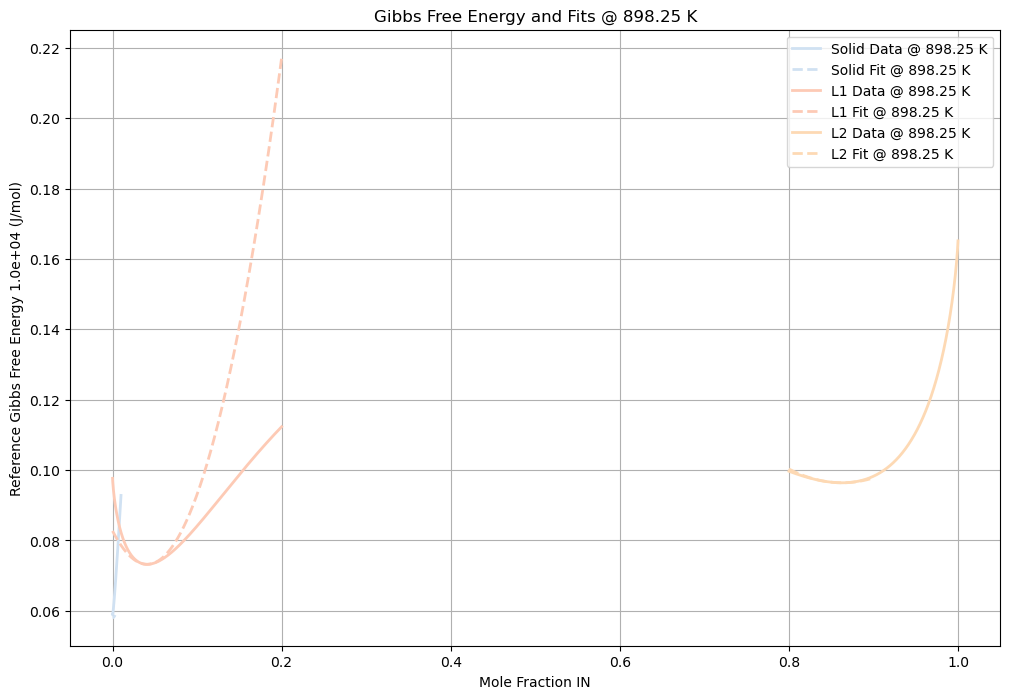


Fit Coefficients at T = 898.25 K
  Solid: 87.04194270451764 3.603852059509682e-05 0.05804408046593779
  L1:    5.683623537673488 0.040840975325869396 0.07321485020524193
  L2:    0.9917558005593117 0.8628079267621621 0.09639548036906274
T = 902.25 K, alpha = 0.200
--- Fit Windows at T = 902.25 K ---
  solid_fit_left:  20
  solid_fit_right: 200000
  l1_fit_left:     16000
  l1_fit_right:    10000
  l2_fit_left:     40000
  l2_fit_right:    10000


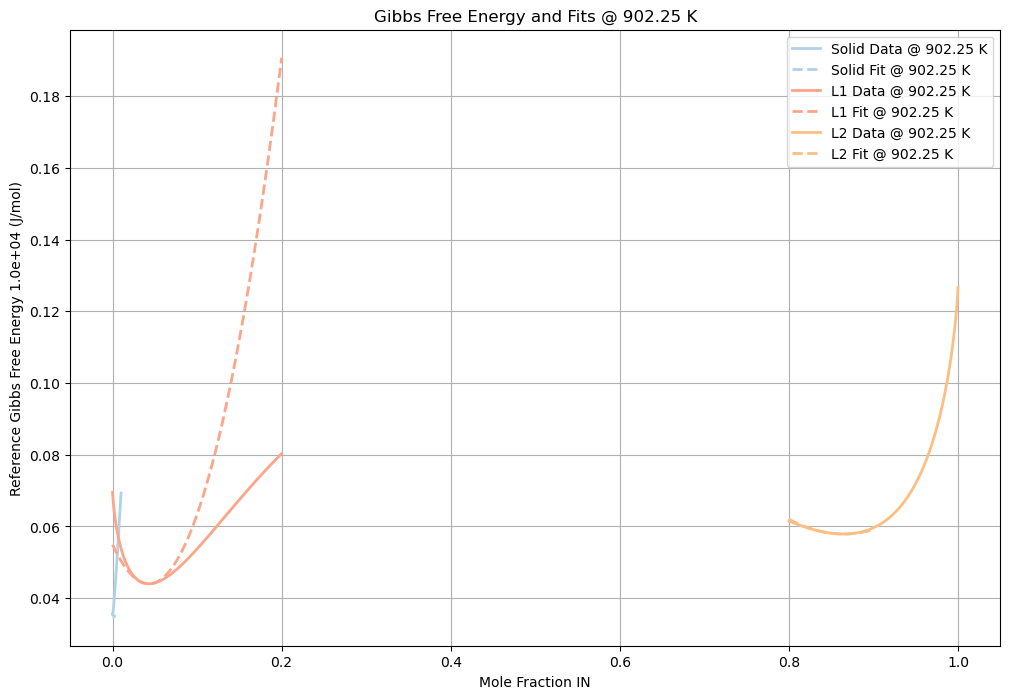


Fit Coefficients at T = 902.25 K
  Solid: 87.04194270451764 3.603852059509682e-05 0.034538738009046964
  L1:    5.9430665484538805 0.042881158918139935 0.04398850333055947
  L2:    0.9917558005593117 0.864675328448527 0.057888168233617227
T = 906.25 K, alpha = 0.400
--- Fit Windows at T = 906.25 K ---
  solid_fit_left:  20
  solid_fit_right: 200000
  l1_fit_left:     22000
  l1_fit_right:    10000
  l2_fit_left:     40000
  l2_fit_right:    10000


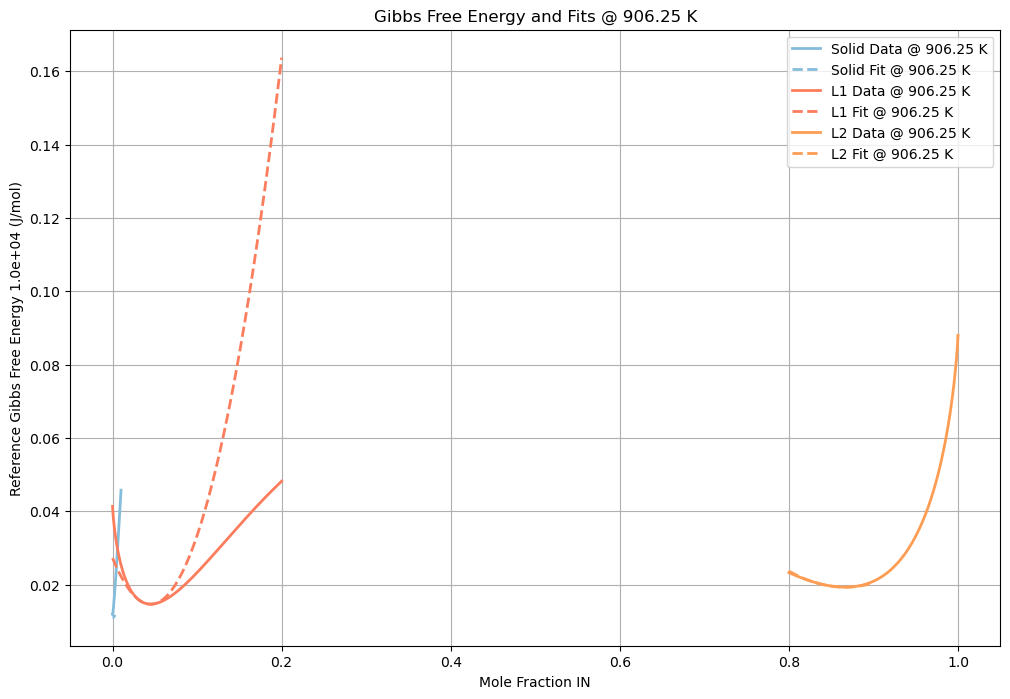


Fit Coefficients at T = 906.25 K
  Solid: 87.04194270451764 3.727655965949531e-05 0.010977216503813982
  L1:    6.2080739745680455 0.045047172206409705 0.014651057596739205
  L2:    0.9917558005593117 0.8664392649804314 0.01932374653906153
T = 910.25 K, alpha = 0.600
--- Fit Windows at T = 910.25 K ---
  solid_fit_left:  20
  solid_fit_right: 200000
  l1_fit_left:     28000
  l1_fit_right:    10000
  l2_fit_left:     40000
  l2_fit_right:    10000


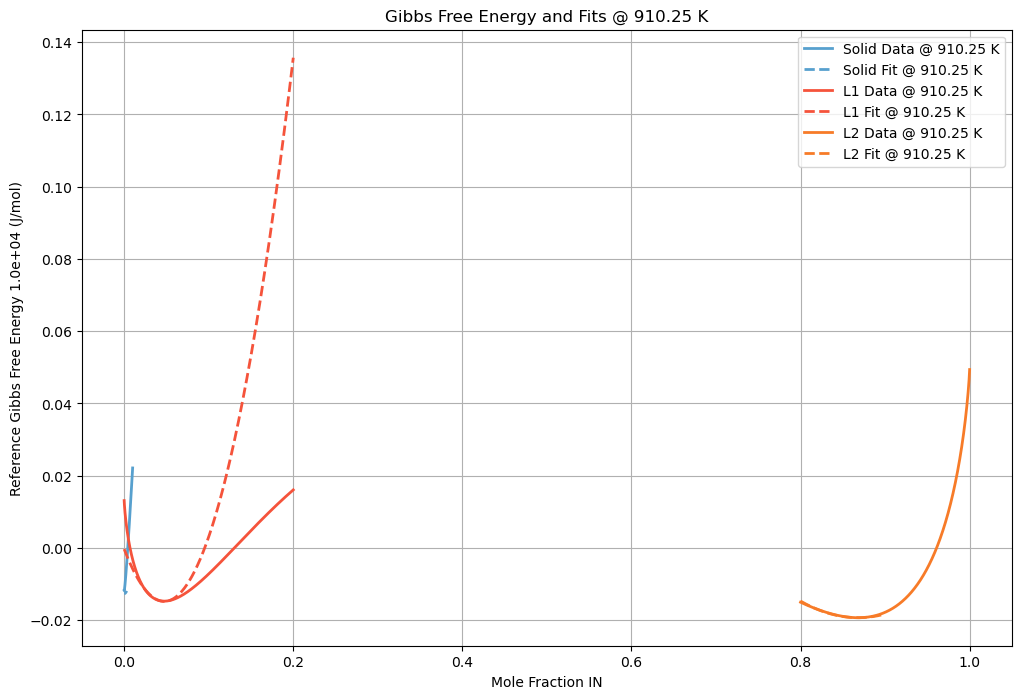


Fit Coefficients at T = 910.25 K
  Solid: 87.04194270451764 3.8019571941712994e-05 -0.012644278251333112
  L1:    6.458342412351527 0.0473560879014015 -0.014795303325729614
  L2:    0.9917558005593117 0.8681106104345095 -0.019297043589784037
T = 914.25 K, alpha = 0.800
--- Fit Windows at T = 914.25 K ---
  solid_fit_left:  20
  solid_fit_right: 200000
  l1_fit_left:     34000
  l1_fit_right:    10000
  l2_fit_left:     40000
  l2_fit_right:    10000


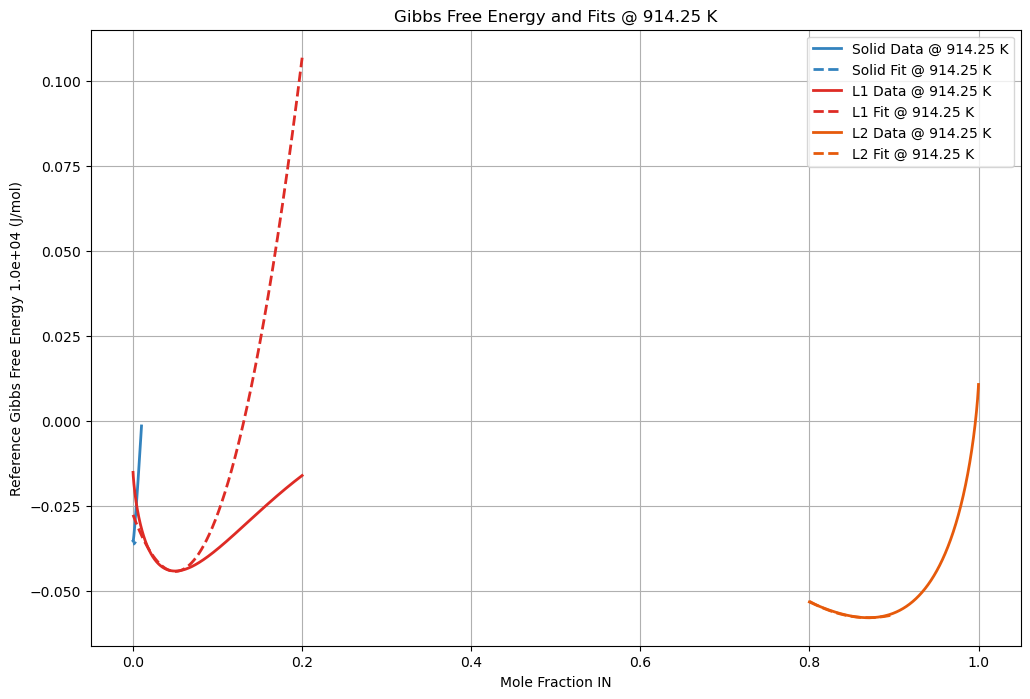


Fit Coefficients at T = 914.25 K
  Solid: 87.04194270451764 3.853669994263367e-05 -0.03632644794244895
  L1:    6.705703658632529 0.04981817840764175 -0.044348376632453015
  L2:    0.9917558005593117 0.8696979205940955 -0.057973558230126614
T = 918.25 K, alpha = 1.000
--- Fit Windows at T = 918.25 K ---
  solid_fit_left:  20
  solid_fit_right: 200000
  l1_fit_left:     40000
  l1_fit_right:    10000
  l2_fit_left:     40000
  l2_fit_right:    10000


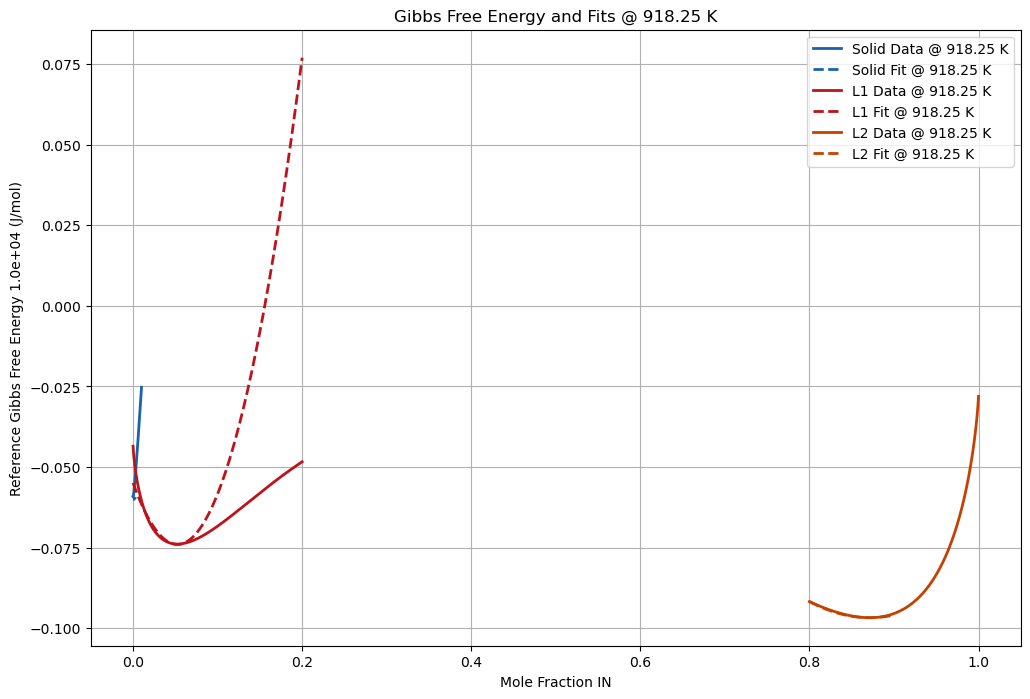


Fit Coefficients at T = 918.25 K
  Solid: 87.04194270451764 3.853669994263367e-05 -0.06006626653811589
  L1:    6.934775337466512 0.05245396940420845 -0.0740055452234161
  L2:    0.9917558005593117 0.8712055828891644 -0.0967051353193345


In [18]:
fit_num = 5  # Number of points on each side of the min point to use for the fit

# === Initialize containers ===
solid_coeffs = {0: [], 1: [], 2: []}
L1_coeffs = {0: [], 1: [], 2: []}
L2_coeffs = {0: [], 1: [], 2: []}
temperatures = []

T_min = min(results.keys())
T_max = max(results.keys())

# === Step 1: Get Te coeff[0] for solid and L2 ===
for T, data in results.items():
    if T != Te:
        continue

    x_solid_sorted = data['x_solid']
    solid_free_energy_sorted = data['solid_free_energy']
    x_l1_sorted = data['x_l1']
    l1_free_energy_sorted = data['l1_free_energy']
    x_l2_sorted = data['x_l1']  # Assuming same grid for L2

    mask_solid = (x_solid_sorted >= mask_solid_min) & \
                 (x_solid_sorted <= mask_solid_max)
    mask_l2 = (x_l2_sorted >= mask_l2_min) & \
              (x_l2_sorted <= mask_l2_max)

    x_solid = x_solid_sorted[mask_solid]
    x_l2 = x_l2_sorted[mask_l2]

    solid_free_energy = solid_free_energy_sorted[mask_solid]
    l2_free_energy = l1_free_energy_sorted[mask_l2]

    energy_solid_reref = solid_free_energy - (common_tangent_slope * x_solid + common_tangent_intercept)
    energy_L2_reref = l2_free_energy - (common_tangent_slope * x_l2 + common_tangent_intercept)

    solid_min_index = np.argmin(energy_solid_reref)
    l2_min_index = np.argmin(energy_L2_reref)

    x_solid_eq = x_solid[solid_min_index]
    x_l2_eq = x_l2[l2_min_index]

    win = interpolate_fit_windows(T, T_min, T_max)
    solid_fit_left = win["solid_left"]
    solid_fit_right = win["solid_right"]
    l2_fit_left = win["l2_left"]
    l2_fit_right = win["l2_right"]

    Te_solid_coeff_0 = np.polyfit(
        x_solid[solid_min_index - fit_num - solid_fit_left : solid_min_index + fit_num + solid_fit_right] - x_solid_eq,
        energy_solid_reref[solid_min_index - fit_num - solid_fit_left : solid_min_index + fit_num + solid_fit_right],
        2
    )[0]
    Te_L2_coeff_0 = np.polyfit(
        x_l2[l2_min_index - fit_num - l2_fit_left : l2_min_index + fit_num + l2_fit_right] - x_l2_eq,
        energy_L2_reref[l2_min_index - fit_num - l2_fit_left : l2_min_index + fit_num + l2_fit_right],
        2
    )[0]
    break

# === Step 2: Main loop ===
for T, data in results.items():
    temperatures.append(T)

    x_solid_sorted = data['x_solid']
    solid_free_energy_sorted = data['solid_free_energy']
    x_l1_sorted = data['x_l1']
    l1_free_energy_sorted = data['l1_free_energy']
    x_l2_sorted = data['x_l1']  # Assuming same grid for L2

    mask_solid = (x_solid_sorted >= mask_solid_min) & \
                 (x_solid_sorted <= mask_solid_max)
    mask_l1 = (x_l1_sorted >= mask_l1_min) & \
              (x_l1_sorted <= mask_l1_max)
    mask_l2 = (x_l2_sorted >= mask_l2_min) & \
              (x_l2_sorted <= mask_l2_max)

    x_solid = x_solid_sorted[mask_solid]
    x_l1 = x_l1_sorted[mask_l1]
    x_l2 = x_l2_sorted[mask_l2]

    solid_free_energy = solid_free_energy_sorted[mask_solid]
    l1_free_energy = l1_free_energy_sorted[mask_l1]
    l2_free_energy = l1_free_energy_sorted[mask_l2]

    energy_solid_reref = solid_free_energy - (common_tangent_slope * x_solid + common_tangent_intercept)
    energy_L1_reref = l1_free_energy - (common_tangent_slope * x_l1 + common_tangent_intercept)
    energy_L2_reref = l2_free_energy - (common_tangent_slope * x_l2 + common_tangent_intercept)

    solid_min_index = np.argmin(energy_solid_reref)
    l1_min_index = np.argmin(energy_L1_reref)
    l2_min_index = np.argmin(energy_L2_reref)

    x_solid_eq = x_solid[solid_min_index]
    x_l1_eq = x_l1[l1_min_index]
    x_l2_eq = x_l2[l2_min_index]

    win = interpolate_fit_windows(T, T_min, T_max)
    solid_fit_left = win["solid_left"]
    solid_fit_right = win["solid_right"]
    l1_fit_left = win["l1_left"]
    l1_fit_right = win["l1_right"]
    l2_fit_left = win["l2_left"]
    l2_fit_right = win["l2_right"]

    print(f"--- Fit Windows at T = {T:.2f} K ---")
    print(f"  solid_fit_left:  {solid_fit_left}")
    print(f"  solid_fit_right: {solid_fit_right}")
    print(f"  l1_fit_left:     {l1_fit_left}")
    print(f"  l1_fit_right:    {l1_fit_right}")
    print(f"  l2_fit_left:     {l2_fit_left}")
    print(f"  l2_fit_right:    {l2_fit_right}")

    # Fit
    solid_coeffs_raw = np.polyfit(
        x_solid[solid_min_index - fit_num - solid_fit_left : solid_min_index + fit_num + solid_fit_right] - x_solid_eq,
        energy_solid_reref[solid_min_index - fit_num - solid_fit_left : solid_min_index + fit_num + solid_fit_right],
        2
    )
    L1_fit_coeffs = np.polyfit(
        x_l1[l1_min_index - fit_num - l1_fit_left : l1_min_index + fit_num + l1_fit_right] - x_l1_eq,
        energy_L1_reref[l1_min_index - fit_num - l1_fit_left : l1_min_index + fit_num + l1_fit_right],
        2
    )
    L2_coeffs_raw = np.polyfit(
        x_l2[l2_min_index - fit_num - l2_fit_left : l2_min_index + fit_num + l2_fit_right] - x_l2_eq,
        energy_L2_reref[l2_min_index - fit_num - l2_fit_left : l2_min_index + fit_num + l2_fit_right],
        2
    )

    # Override coeff[0] for solid and L2 with Te values
    solid_fit_coeffs = [Te_solid_coeff_0, solid_coeffs_raw[1], solid_coeffs_raw[2]]
    L2_fit_coeffs = [Te_L2_coeff_0, L2_coeffs_raw[1], L2_coeffs_raw[2]]

    # Plotting
    x_fit = np.linspace(0, 0.003, 1000)
    x_fit_l1 = np.linspace(0, 0.2, 1000)
    x_fit_l2 = np.linspace(0.8, 0.9, 1000)

    solid_fit_curve = solid_fit_coeffs[0] * (x_fit - x_solid_eq) ** 2 + solid_fit_coeffs[2]
    L1_fit_curve = L1_fit_coeffs[0] * (x_fit_l1 - x_l1_eq) ** 2 + L1_fit_coeffs[2]
    L2_fit_curve = L2_fit_coeffs[0] * (x_fit_l2 - x_l2_eq) ** 2 + L2_fit_coeffs[2]

    color_solid = cmap_solid(norm(T))
    color_l1 = cmap_l1(norm(T))
    color_l2 = cmap_l2(norm(T))

    plt.figure(figsize=(12, 8))
    plt.plot(x_solid, energy_solid_reref, '-', color=color_solid, label=f'Solid Data @ {T:.2f} K', linewidth=2)
    plt.plot(x_fit, solid_fit_curve, '--', color=color_solid, label=f'Solid Fit @ {T:.2f} K', linewidth=2)

    plt.plot(x_l1, energy_L1_reref, '-', color=color_l1, label=f'L1 Data @ {T:.2f} K', linewidth=2)
    plt.plot(x_fit_l1, L1_fit_curve, '--', color=color_l1, label=f'L1 Fit @ {T:.2f} K', linewidth=2)

    plt.plot(x_l2, energy_L2_reref, '-', color=color_l2, label=f'L2 Data @ {T:.2f} K', linewidth=2)
    plt.plot(x_fit_l2, L2_fit_curve, '--', color=color_l2, label=f'L2 Fit @ {T:.2f} K', linewidth=2)

    plt.xlabel('Mole Fraction ' + reference_element)
    plt.ylabel('Reference Gibbs Free Energy ' + f"{1/energy_scale:.1e}" + ' (J/mol)')
    plt.title(f'Gibbs Free Energy and Fits @ {T:.2f} K')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nFit Coefficients at T = {T:.2f} K")
    print("  Solid:", solid_fit_coeffs[0], x_solid_eq, solid_fit_coeffs[2])
    print("  L1:   ", L1_fit_coeffs[0], x_l1_eq, L1_fit_coeffs[2])
    print("  L2:   ", L2_fit_coeffs[0], x_l2_eq, L2_fit_coeffs[2])

    solid_coeffs[0].append(solid_fit_coeffs[0])
    L1_coeffs[0].append(L1_fit_coeffs[0])
    L2_coeffs[0].append(L2_fit_coeffs[0])

    solid_coeffs[1].append(x_solid_eq)
    L1_coeffs[1].append(x_l1_eq)
    L2_coeffs[1].append(x_l2_eq)

    solid_coeffs[2].append(solid_fit_coeffs[2])
    L1_coeffs[2].append(L1_fit_coeffs[2])
    L2_coeffs[2].append(L2_fit_coeffs[2])


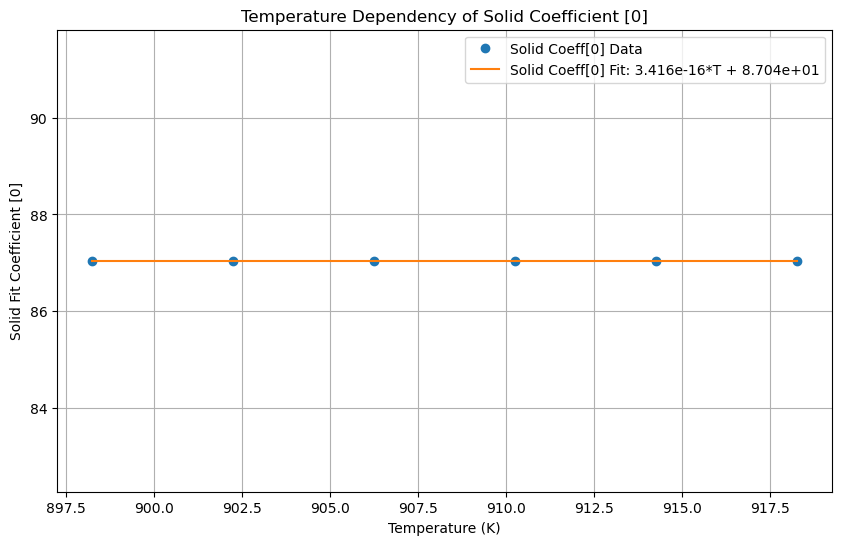

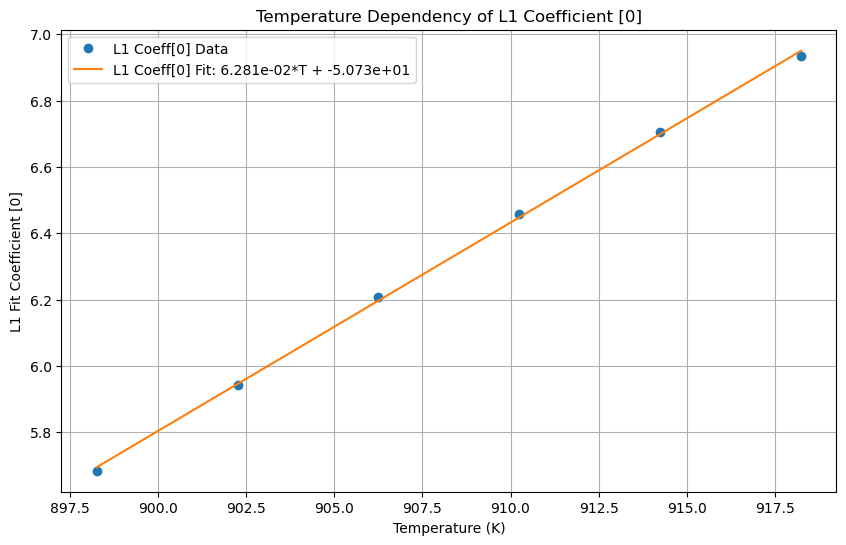

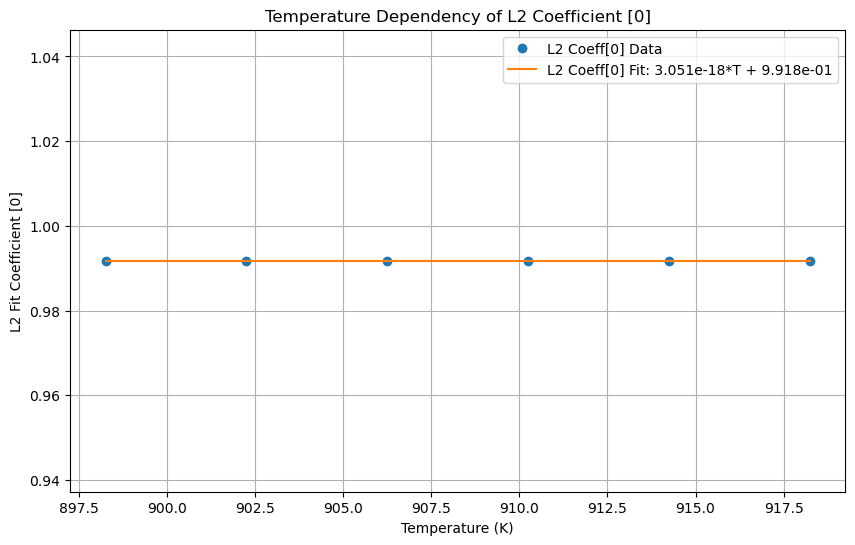

Solid Coeff[0] Linear Fit: a = 3.416e-16, b = 8.704e+01
L1 Coeff[0] Linear Fit: a = 6.281e-02, b = -5.073e+01
L2 Coeff[0] Linear Fit: a = 3.051e-18, b = 9.918e-01


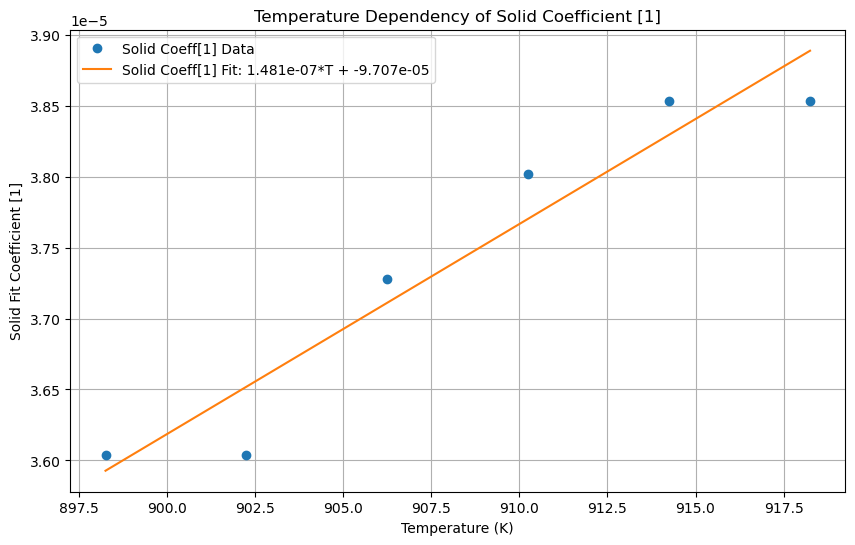

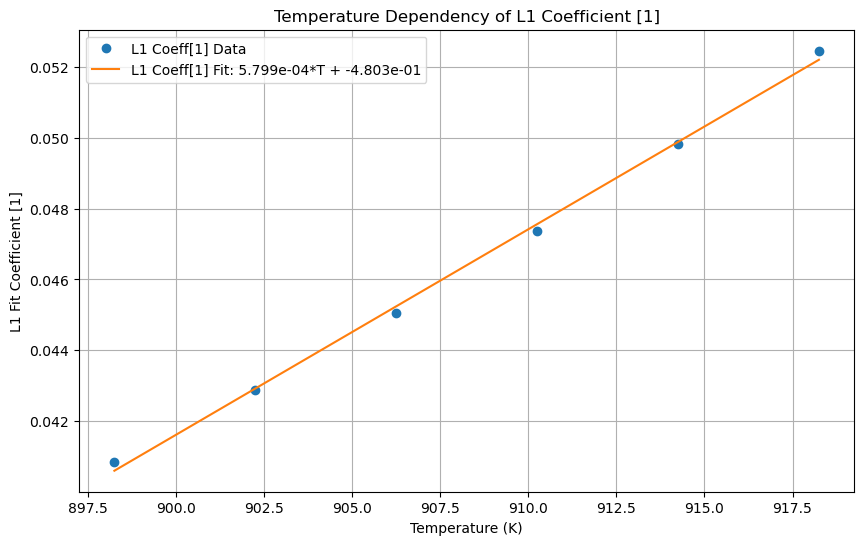

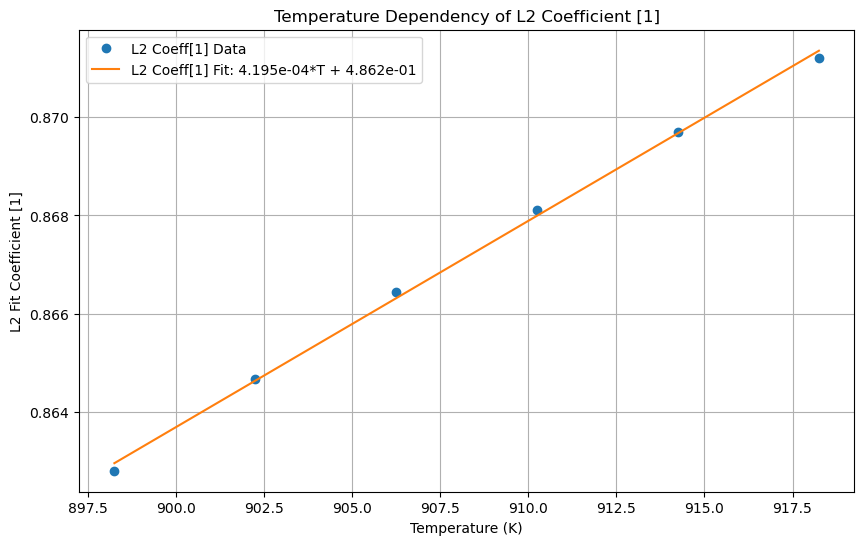

Solid Coeff[1] Linear Fit: a = 1.481e-07, b = -9.707e-05
L1 Coeff[1] Linear Fit: a = 5.799e-04, b = -4.803e-01
L2 Coeff[1] Linear Fit: a = 4.195e-04, b = 4.862e-01


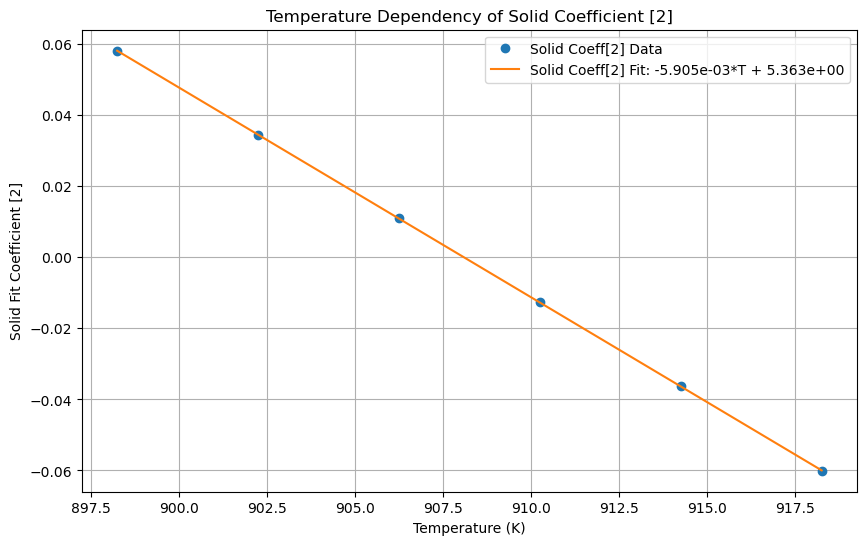

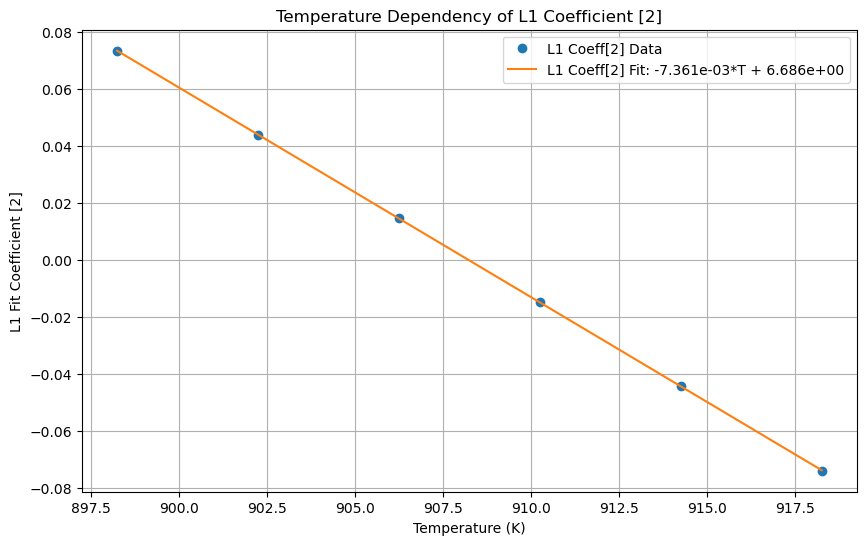

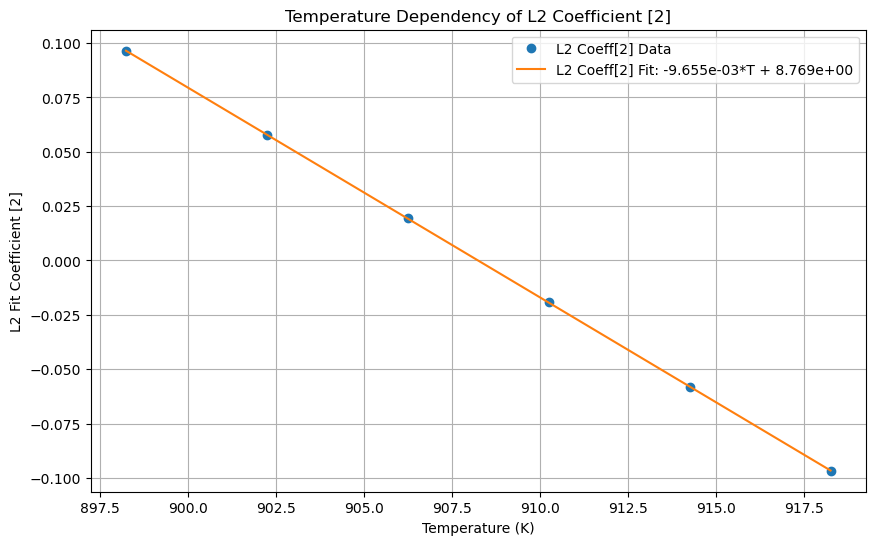

Solid Coeff[2] Linear Fit: a = -5.905e-03, b = 5.363e+00
L1 Coeff[2] Linear Fit: a = -7.361e-03, b = 6.686e+00
L2 Coeff[2] Linear Fit: a = -9.655e-03, b = 8.769e+00


In [19]:
# Convert lists to numpy arrays for linear regression
temperatures = np.array(temperatures)
for i in (0, 1, 2):
    solid_coeffs[i] = np.array(solid_coeffs[i])
    L1_coeffs[i] = np.array(L1_coeffs[i])
    L2_coeffs[i] = np.array(L2_coeffs[i])

# Fit and plot for each coefficient index and phase
for i in (0, 1, 2):
    solid_params = fit_and_plot_coeffs(solid_coeffs[i], 'Solid', i)
    L1_params = fit_and_plot_coeffs(L1_coeffs[i], 'L1', i)
    L2_params = fit_and_plot_coeffs(L2_coeffs[i], 'L2', i)

    print(f"Solid Coeff[{i}] Linear Fit: a = {solid_params[0]:.3e}, b = {solid_params[1]:.3e}")
    print(f"L1 Coeff[{i}] Linear Fit: a = {L1_params[0]:.3e}, b = {L1_params[1]:.3e}")
    print(f"L2 Coeff[{i}] Linear Fit: a = {L2_params[0]:.3e}, b = {L2_params[1]:.3e}")

In [20]:
# Fit linear params for each coefficient index
solid_fit_params = {}
L1_fit_params = {}
L2_fit_params = {}

for i in (0, 1, 2):
    solid_fit_params[i] = np.polyfit(temperatures, solid_coeffs[i], 1)
    L1_fit_params[i] = np.polyfit(temperatures, L1_coeffs[i], 1)
    L2_fit_params[i] = np.polyfit(temperatures, L2_coeffs[i], 1)

print("\nFormatted linear fit parameters:\n")

# Mapping for prefixes by coeff index
prefix_map = {0: 'A', 1: 'B', 2: 'C'}

for i in (0, 1, 2):
    prefix = prefix_map[i]
    # Solid (_3 suffix)
    print(f"{prefix}1_3 = {solid_fit_params[i][0]: .3e}; {prefix}0_3 = {solid_fit_params[i][1]: .3e};")
    # L1 (_1 suffix)
    print(f"{prefix}1_1 = {L1_fit_params[i][0]: .3e}; {prefix}0_1 = {L1_fit_params[i][1]: .3e};")
    # L2 (_2 suffix)
    print(f"{prefix}1_2 = {L2_fit_params[i][0]: .3e}; {prefix}0_2 = {L2_fit_params[i][1]: .3e};\n")



Formatted linear fit parameters:

A1_3 =  3.416e-16; A0_3 =  8.704e+01;
A1_1 =  6.281e-02; A0_1 = -5.073e+01;
A1_2 =  3.051e-18; A0_2 =  9.918e-01;

B1_3 =  1.481e-07; B0_3 = -9.707e-05;
B1_1 =  5.799e-04; B0_1 = -4.803e-01;
B1_2 =  4.195e-04; B0_2 =  4.862e-01;

C1_3 = -5.905e-03; C0_3 =  5.363e+00;
C1_1 = -7.361e-03; C0_1 =  6.686e+00;
C1_2 = -9.655e-03; C0_2 =  8.769e+00;



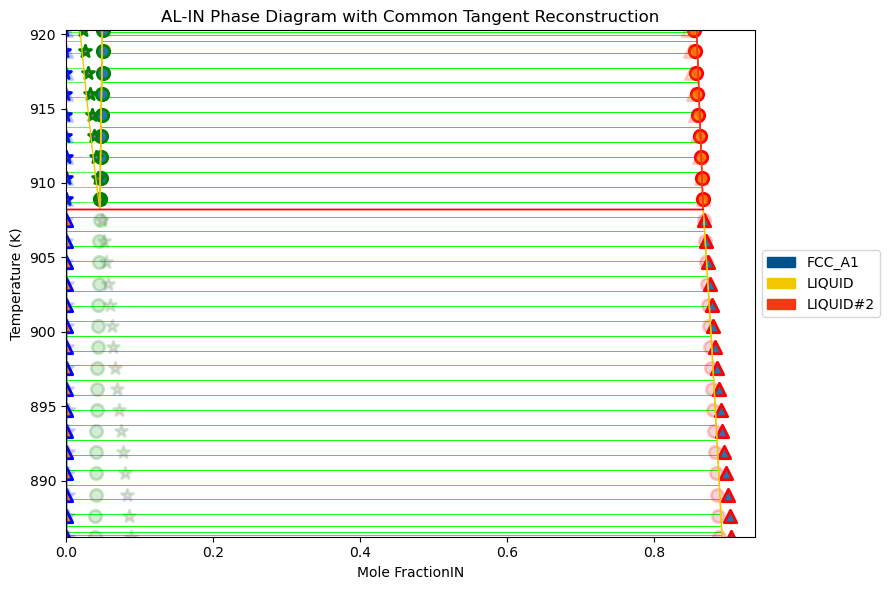

In [22]:
# ========== Define Thermodynamic Coefficients ==========

# Mapping for prefixes by coeff index
prefix_map = {0: 'A', 1: 'B', 2: 'C'}
fit_params = {
    '3': solid_fit_params,  # Solid
    '1': L1_fit_params,     # L1
    '2': L2_fit_params      # L2
}

for i in (0, 1, 2):
    prefix = prefix_map[i]
    
    for suffix, params in fit_params.items():
        # param index 0 (coeff 1)
        var_name_1 = f"{prefix}1_{suffix}"
        globals()[var_name_1] = params[i][0]
        
        # param index 1 (coeff 0)
        var_name_0 = f"{prefix}0_{suffix}"
        globals()[var_name_0] = params[i][1]


# ========== Temperature Settings ==========
T0 = 886.25
Tt = 920.25
T_mono = 908.25
n = 25
T_array = np.linspace(T0, Tt, n)

# ========== Settings ==========
T_min = 886.25 # Kelvin
T_max = 920.25 # Kelvin
T_interval = 1
T_mono = 908.25
n = 25
T_array = np.linspace(T_min, T_max, n)

C_min = 0.0
C_max = 1.0
C_interval = 0.02

# ========== Storage Arrays ==========
x1_12, x2_12 = np.zeros(n), np.zeros(n)
x1_13, x3_13 = np.zeros(n), np.zeros(n)
x2_23, x3_23 = np.zeros(n), np.zeros(n)

# ========== Compute All Tangents ==========
for i, T in enumerate(T_array):
    A1 = (A1_1*T + A0_1) / energy_scale
    B1 = (B1_1*T + B0_1)
    C1 = (C1_1*T + C0_1) / energy_scale

    A2 = (A1_2*T + A0_2) / energy_scale
    B2 = (B1_2*T + B0_2)
    C2 = (C1_2*T + C0_2) / energy_scale

    A3 = (A1_3*T + A0_3) / energy_scale
    B3 = (B1_3*T + B0_3)
    C3 = (C1_3*T + C0_3) / energy_scale

    x1_12[i], x2_12[i] = calculate_common_tangent(A1, B1, C1, A2, B2, C2)
    x1_13[i], x3_13[i] = calculate_common_tangent(A1, B1, C1, A3, B3, C3)
    x2_23[i], x3_23[i] = calculate_common_tangent(A2, B2, C2, A3, B3, C3)

# ========== Plotting ==========
fig, ax = plt.subplots(figsize=(9,6))

# --- Phase Diagram Overlay ---
binplot(tdb_content, my_elements, my_phases,
        {v.X(reference_element):(C_min, C_max, C_interval), v.T:(T_min, T_max, T_interval), v.P:Pressure, v.N:1},
        plot_kwargs={'ax': ax})


# --- Calculated Tangent Points ---
above = T_array >= T_mono
below = ~above

# 1-2
ax.scatter(x1_12[above], T_array[above], 80, marker='o', edgecolors=[0, 0.5, 0], linewidths=2)
ax.scatter(x2_12[above], T_array[above], 80, marker='o', edgecolors='r', linewidths=2)
ax.scatter(x1_12[below], T_array[below], 80, marker='o', edgecolors=[0, 0.5, 0], linewidths=2, alpha=0.2)
ax.scatter(x2_12[below], T_array[below], 80, marker='o', edgecolors='r', linewidths=2, alpha=0.2)

# 1-3
ax.scatter(x1_13[above], T_array[above], 80, marker='*', edgecolors=[0, 0.5, 0], linewidths=2)
ax.scatter(x3_13[above], T_array[above], 80, marker='*', edgecolors='b', linewidths=2)
ax.scatter(x1_13[below], T_array[below], 80, marker='*', edgecolors=[0, 0.5, 0], linewidths=2, alpha=0.2)
ax.scatter(x3_13[below], T_array[below], 80, marker='*', edgecolors='b', linewidths=2, alpha=0.2)

# 2-3
ax.scatter(x2_23[above], T_array[above], 80, marker='^', edgecolors='r', linewidths=2, alpha=0.2)
ax.scatter(x3_23[above], T_array[above], 80, marker='^', edgecolors='b', linewidths=2, alpha=0.2)
ax.scatter(x2_23[below], T_array[below], 80, marker='^', edgecolors='r', linewidths=2)
ax.scatter(x3_23[below], T_array[below], 80, marker='^', edgecolors='b', linewidths=2)

# === Labels ===
ax.set_xlabel('Mole Fraction' + reference_element)
ax.set_ylabel('Temperature (K)')
ax.set_title(my_elements[0] + '-' + my_elements[1] + ' Phase Diagram with Common Tangent Reconstruction')


plt.tight_layout()
plt.show()
